# Demo 4: Monitor Quality of Network Embeddings
h-NNE generates a representation which follows some of the clustering properties of the data in the initial space. This allows for a simple qualitative evaluation of feature spaces. In this notebook, we pass the CIFAR-10 dataset through a ResNet18 network and extract all the intermediate outputs of the main blocks. When embedded to 2D with h-NNE, one can visualize the gradual disentanglement that occurs while going deeper through the network.

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import torch

from hnne import HNNE

## Getting the CIFAR-10 pre-trained networks and the repo with the model definitions
The models used for the experiment come from the following repository: https://github.com/huyvnphan/PyTorch_CIFAR10. The repository contains a collection of common networks availably in torchvision which are adapted and trained on CIFAR-10. You can use the command below to clone the repository. Then you need to download the models from the link to Google Drive provided in the repository and expand and copy them to 'PyTorch_CIFAR10/cifar10_models/'.


In [2]:
!git clone git@github.com:huyvnphan/PyTorch_CIFAR10.git

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 690, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 690 (delta 52), reused 36 (delta 36), pack-reused 624 (from 1)
Receiving objects: 100% (690/690), 6.58 MiB | 7.17 MiB/s, done.
Resolving deltas: 100% (269/269), done.


In [4]:
from PyTorch_CIFAR10.cifar10_models import resnet

## Load the ResNet18 network and CIFAR-10
In case no gpu is available, one can set the devive name to cpu. The inference will take much longer, so one can also subsample the dataset to run the notebook quickly.

In [5]:
device = torch.device('cuda:0')
resnet_cifar = resnet.resnet18(pretrained=True)
resnet_cifar.to(device)
resnet_cifar.eval()

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2471, 0.2435, 0.2616))
])

layers = list(resnet_cifar.children())
initial_conv = torch.nn.Sequential(*layers[:4])
intermediate_blocks = layers[4:8]

/home/marios/repos/h-nne/notebooks/hnne_v2/PyTorch_CIFAR10/cifar10_models/resnet.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [6]:
cifar10_train = CIFAR10(root='..', download=True, train=True)
cifar10_test = CIFAR10(root='..', download=True, train=True)

Files already downloaded and verified
Files already downloaded and verified


## Extract values of all intermediate blocks

In [7]:
intermediate_outputs = [[], [], [], [], []]

for img, label in tqdm(cifar10_train):
    with torch.no_grad():
        img = transform(img).unsqueeze(0).to(device)
        output = initial_conv(img)
        intermediate_outputs[0].append(output.cpu().detach().numpy())
        for i, block in enumerate(intermediate_blocks, start=1):
            output = block(output)
            intermediate_outputs[i].append(output.cpu().detach().numpy())
        
for i in range(len(intermediate_outputs)):
    intermediate_outputs[i] = np.vstack(intermediate_outputs[i]).reshape((len(cifar10_train), -1))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:02<00:00, 804.45it/s]


## Project the data and all intermediate outputs with h-NNE

In [8]:
%%time
hnne = HNNE(hnne_version="v2")
projection_data = hnne.fit_transform(cifar10_train.data.reshape(-1, 32*32*3))

CPU times: user 1min 47s, sys: 23.5 s, total: 2min 11s
Wall time: 19.5 s


In [9]:
%%time
intermediate_projections = [[], [], [], [], []]
for i in tqdm(list(range(len(intermediate_outputs)))):
    intermediate_projections[i] = HNNE(hnne_version="v2").fit_transform(intermediate_outputs[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:26<00:00, 17.28s/it]

CPU times: user 19min 14s, sys: 2min 37s, total: 21min 52s
Wall time: 1min 26s


## Plot the embeddings
One can observe how the separation of targets in different clusters reflects the increasing quality of the features as one goes deeper through the network.

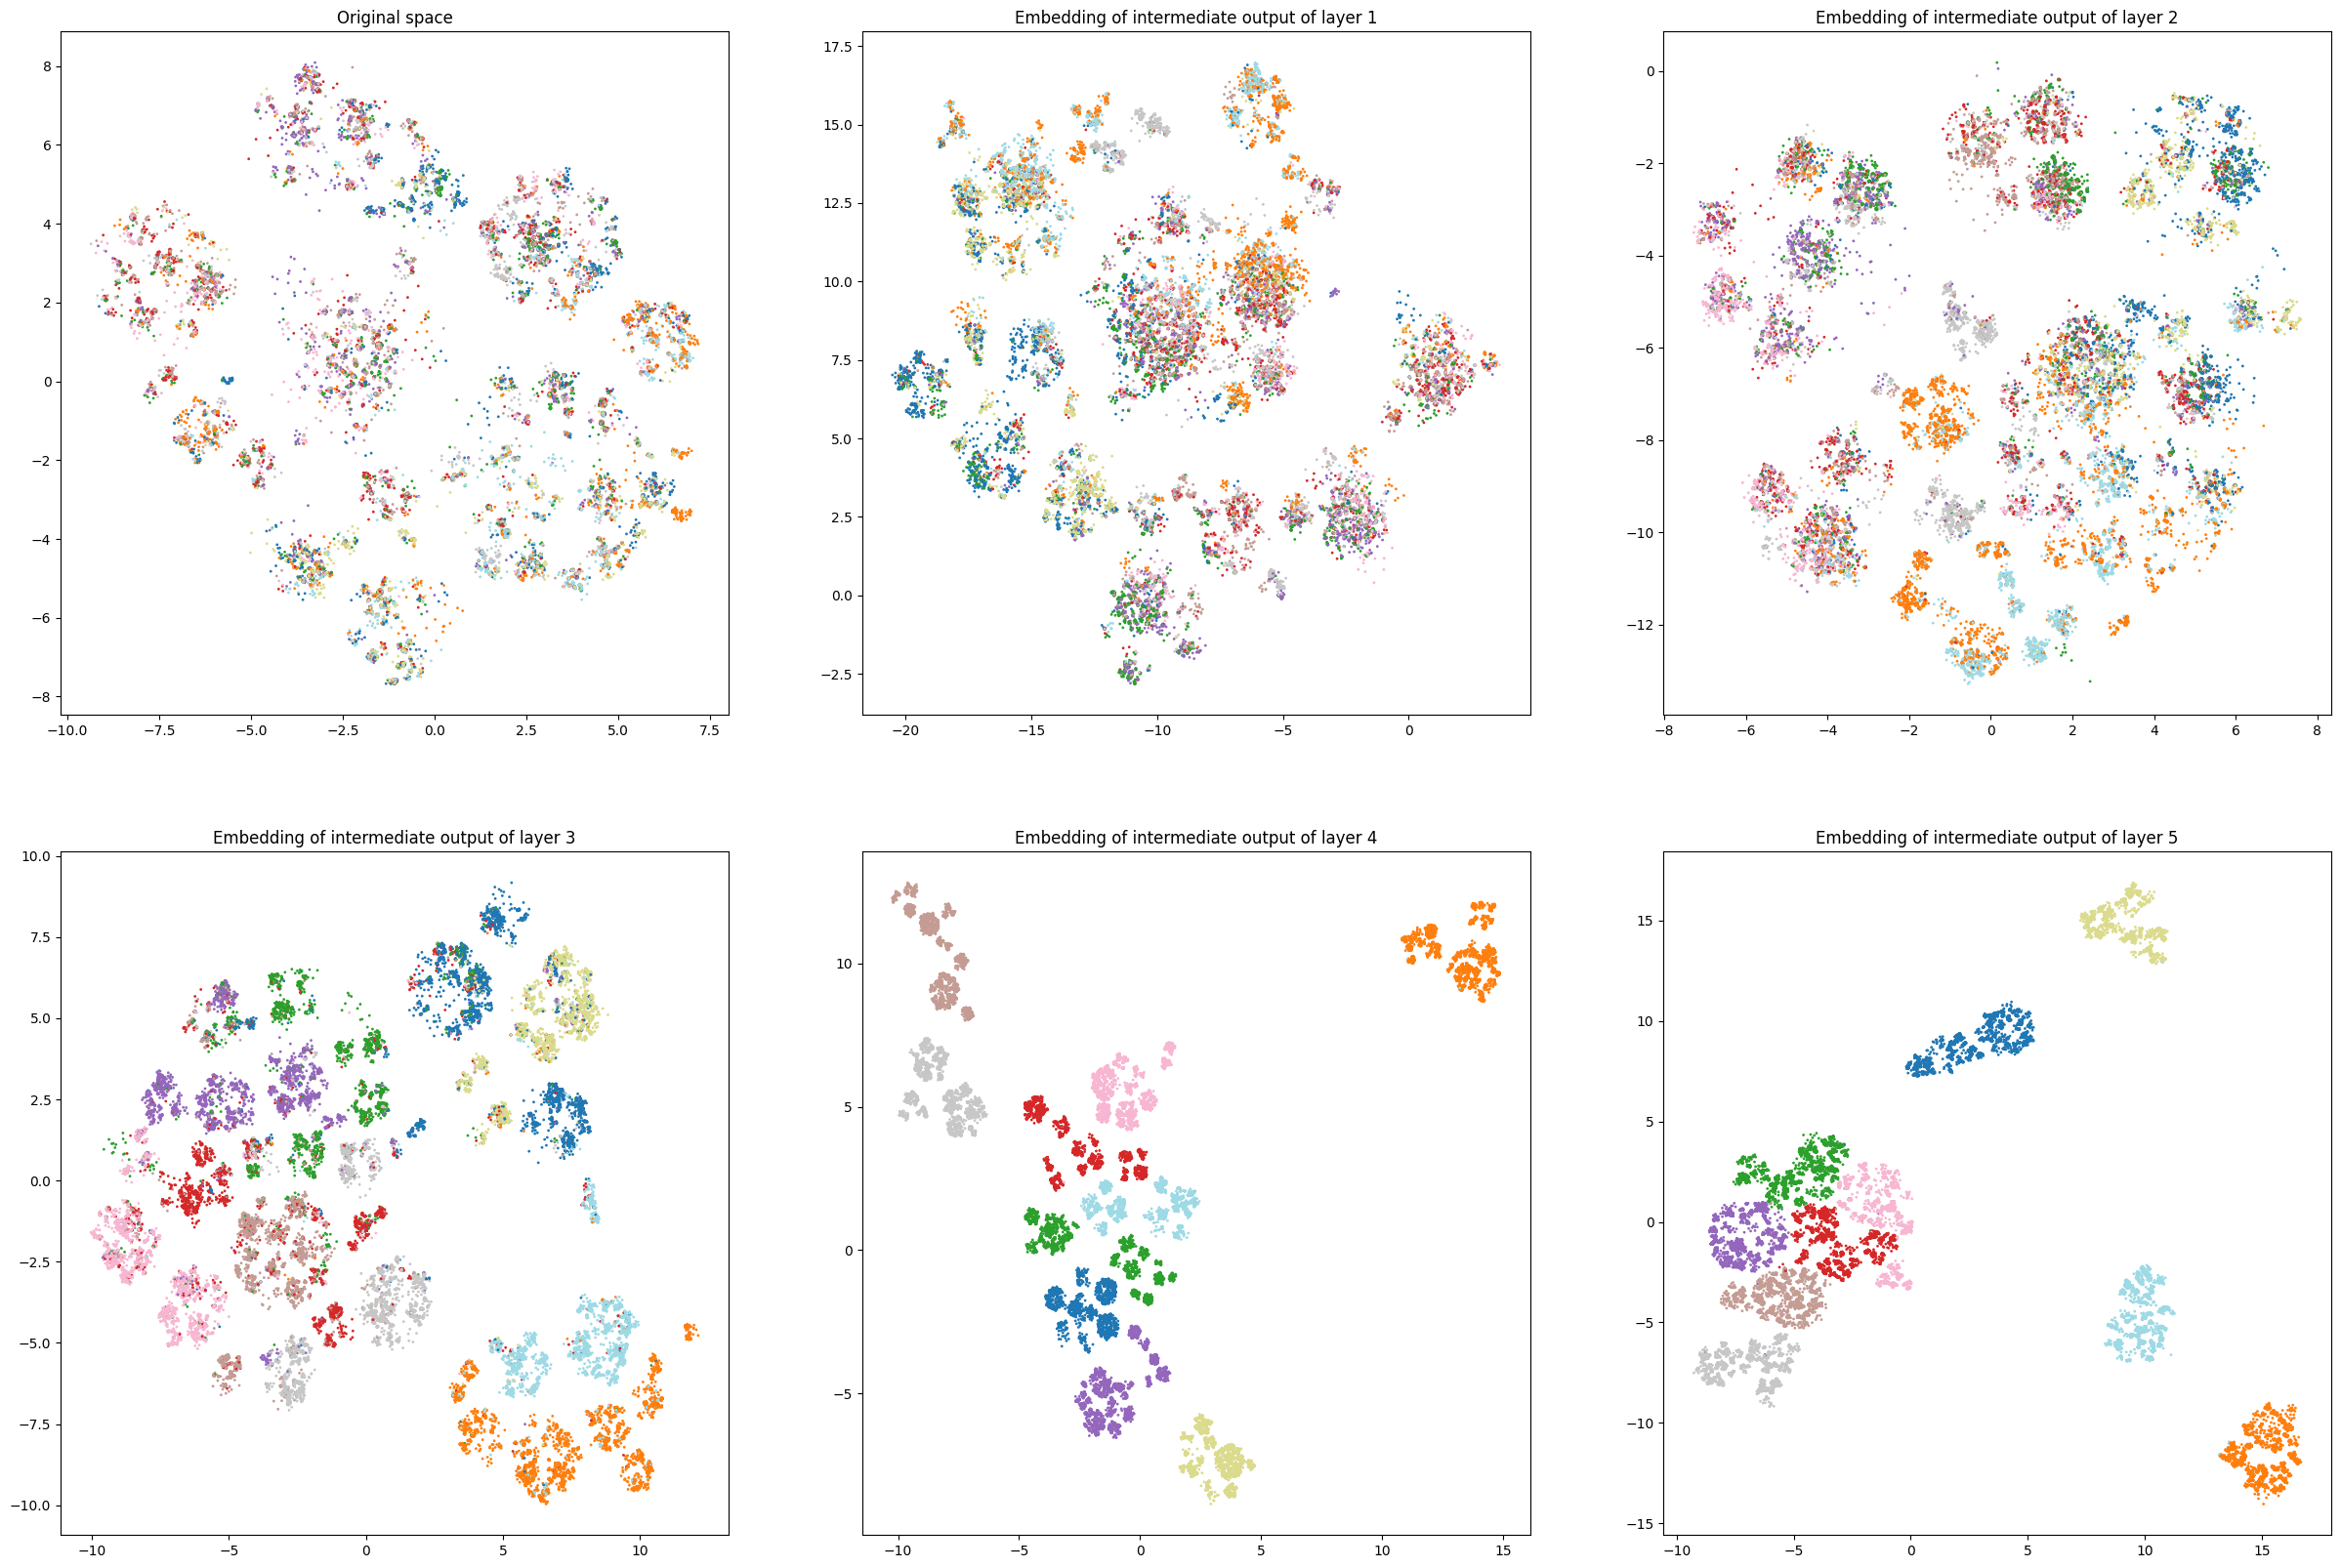

In [10]:
_, ax = plt.subplots(2, 3, figsize=(10*3, 10*2))

ax[0][0].set_title('Original space')
ax[0][0].scatter(*projection_data.T, s=1, c=cifar10_train.targets, cmap='tab20')

for i, intermediate in enumerate(intermediate_projections, start=1):
    ax[i//3][i%3].set_title(f'Embedding of intermediate output of layer {i}')
    ax[i//3][i%3].scatter(*intermediate.T, s=1, c=cifar10_train.targets, cmap='tab20')
plt.show()